<a href="https://colab.research.google.com/github/hadar424/my_final_project/blob/main/final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import time
import copy
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
train_data_path = "./drive/MyDrive/final_project/data/fruits-360-dataset/fruits-360/Training"
test_data_path = "./drive/MyDrive/final_project/data/fruits-360-dataset/fruits-360/Test"

In [4]:
batch_size = 131
model1_transforms = transforms.Compose(
[
    transforms.ToTensor()
])

train_dataset1 = datasets.ImageFolder(root= train_data_path, transform=model1_transforms)
test_dataset1 = datasets.ImageFolder(root= test_data_path, transform=model1_transforms)
train_dataloader1 = DataLoader(train_dataset1, batch_size=batch_size, shuffle=True)
test_dataloader1 = DataLoader(test_dataset1, batch_size=batch_size, shuffle=True)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
images, labels = next(iter(train_dataloader1)) 
print("images-size:", images.shape)
print("labels-size:", labels.shape)

images-size: torch.Size([131, 3, 100, 100])
labels-size: torch.Size([131])


In [5]:
model1 = models.resnet18(pretrained=True)
model1 = model1.cuda() if device else model1
criterion1 = nn.CrossEntropyLoss()
sgd_optimizer1 = optim.SGD(model1.parameters(), lr=0.0001, momentum=0.9)

num_features = model1.fc.in_features
model1.fc = nn.Linear(num_features, batch_size)
model1.fc = model1.fc.cuda()

In [6]:
def train_model(model,n_epochs, loss_func, optimizer, train_dataloader, test_dataloader, d_device):
  valid_loss_min = np.Inf
  val_loss = []
  val_acc = []
  train_loss = []
  train_acc = []
  total_step = len(train_dataloader)
  for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_dataloader):
      data_, target_ = data_.to(d_device), target_.to(d_device)
      optimizer.zero_grad()
      outputs = model(data_)
      loss = loss_func(outputs, target_)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      _,pred = torch.max(outputs, dim=1)
      correct += torch.sum(pred==target_).item()
      total += target_.size(0)
      if (batch_idx) % 100 == 0:
        print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
        .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        loss_func.eval()
        for data_t, target_t in (test_dataloader):
            data_t, target_t = data_t.to(d_device), target_t.to(d_device)
            outputs_t = model(data_t)
            loss_t = loss_func(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t/total_t)
        val_loss.append(batch_loss/len(test_dataloader))
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')
    model.train()
  return train_acc,val_acc

In [7]:
epoches = 15
train_acc1,val_acc1 = train_model(model1,epoches,criterion1,sgd_optimizer1,train_dataloader1,test_dataloader1,device)

Epoch 1

Epoch [1/15], Step [0/201], Loss: 5.1451
Epoch [1/15], Step [100/201], Loss: 4.6741
Epoch [1/15], Step [200/201], Loss: 4.4472

train-loss: 4.7563, train-acc: 4.0340
validation loss: 4.4487, validation acc: 8.8422

Epoch 2

Epoch [2/15], Step [0/201], Loss: 4.2657
Epoch [2/15], Step [100/201], Loss: 3.8922
Epoch [2/15], Step [200/201], Loss: 4.8356

train-loss: 4.3473, train-acc: 24.4447
validation loss: 4.1369, validation acc: 28.6641

Epoch 3

Epoch [3/15], Step [0/201], Loss: 3.6879
Epoch [3/15], Step [100/201], Loss: 3.2098
Epoch [3/15], Step [200/201], Loss: 3.7528

train-loss: 4.0011, train-acc: 46.8972
validation loss: 3.8716, validation acc: 44.7201

Epoch 4

Epoch [4/15], Step [0/201], Loss: 2.9732
Epoch [4/15], Step [100/201], Loss: 2.8837
Epoch [4/15], Step [200/201], Loss: 5.4423

train-loss: 3.7097, train-acc: 63.6249
validation loss: 3.6438, validation acc: 56.5903

Epoch 5

Epoch [5/15], Step [0/201], Loss: 2.6186
Epoch [5/15], Step [100/201], Loss: 2.4440
Epoch

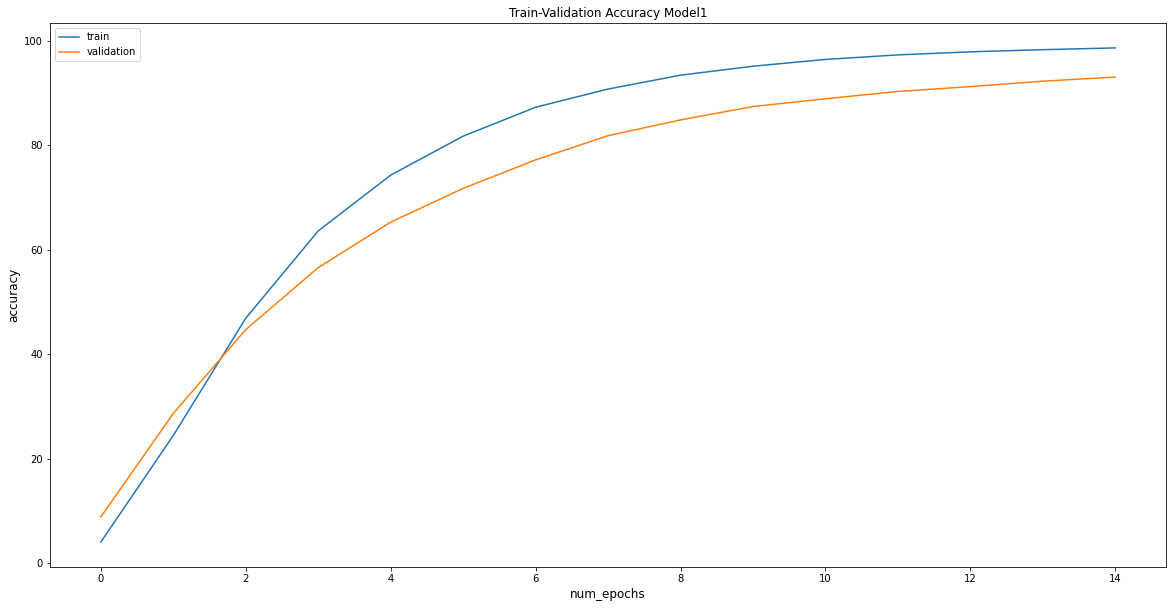

In [8]:
fig = plt.figure(figsize=(20,10))
plt.title("Train-Validation Accuracy Model1")
plt.plot(train_acc1, label='train')
plt.plot(val_acc1, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')

In [9]:
def visualize_model(model, num_images, test_dataloader, test_dataset):
    images_so_far = 0
    fig = plt.figure(figsize=(8, 5))
    for i, data in enumerate(test_dataloader):
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        preds = preds.cpu()
        preds = preds.numpy()
        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(2, num_images//2, images_so_far)
            ax.axis('off')
            ax.set_title('predictes: {}'.format(test_dataset.classes[preds[j]]))
            inputs = inputs.cpu()
            image = inputs[j].squeeze().permute(1,2,0)
            plt.imshow(image)
            
            if images_so_far == num_images:
                return 

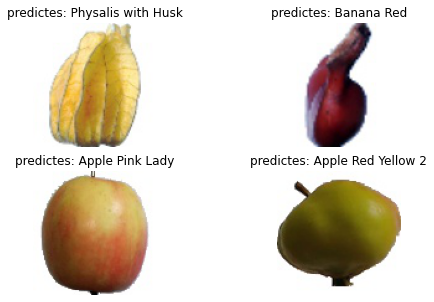

In [10]:
plt.ion()
visualize_model(model1, 4, test_dataloader1, test_dataset1)
plt.ioff()

In [11]:
model2_transforms = transforms.Compose(
[
    transforms.ToTensor(),
    transforms.Grayscale(3),
])

train_dataset2 = datasets.ImageFolder(root= train_data_path, transform=model2_transforms)
test_dataset2 = datasets.ImageFolder(root= test_data_path, transform=model2_transforms)
train_dataloader2 = DataLoader(train_dataset2, batch_size=batch_size, shuffle=True)
test_dataloader2 = DataLoader(test_dataset2, batch_size=batch_size, shuffle=True)

model2 = models.resnet18(pretrained=True)
model2 = model2.cuda() if device else model2

criterion2 = nn.CrossEntropyLoss()
sgd_optimizer2 = optim.SGD(model2.parameters(), lr=0.0001, momentum=0.9)

num_features = model2.fc.in_features
model2.fc = nn.Linear(num_features, batch_size)
model2.fc = model2.fc.cuda()

In [12]:
train_acc2,val_acc2 = train_model(model2,epoches,criterion2,sgd_optimizer2,train_dataloader2,test_dataloader2,device)

Epoch 1

Epoch [1/15], Step [0/201], Loss: 5.2188
Epoch [1/15], Step [100/201], Loss: 4.6554
Epoch [1/15], Step [200/201], Loss: 4.9348

train-loss: 4.7558, train-acc: 4.1180
validation loss: 4.4425, validation acc: 7.9517

Epoch 2

Epoch [2/15], Step [0/201], Loss: 4.2553
Epoch [2/15], Step [100/201], Loss: 3.9752
Epoch [2/15], Step [200/201], Loss: 4.4071

train-loss: 4.3598, train-acc: 19.8229
validation loss: 4.1618, validation acc: 23.6514

Epoch 3

Epoch [3/15], Step [0/201], Loss: 3.8652
Epoch [3/15], Step [100/201], Loss: 3.5193
Epoch [3/15], Step [200/201], Loss: 4.9912

train-loss: 4.0361, train-acc: 39.0963
validation loss: 3.9220, validation acc: 38.5369

Epoch 4

Epoch [4/15], Step [0/201], Loss: 3.0393
Epoch [4/15], Step [100/201], Loss: 2.8652
Epoch [4/15], Step [200/201], Loss: 4.6682

train-loss: 3.7636, train-acc: 55.1141
validation loss: 3.7197, validation acc: 48.1043

Epoch 5

Epoch [5/15], Step [0/201], Loss: 2.7362
Epoch [5/15], Step [100/201], Loss: 2.5866
Epoch

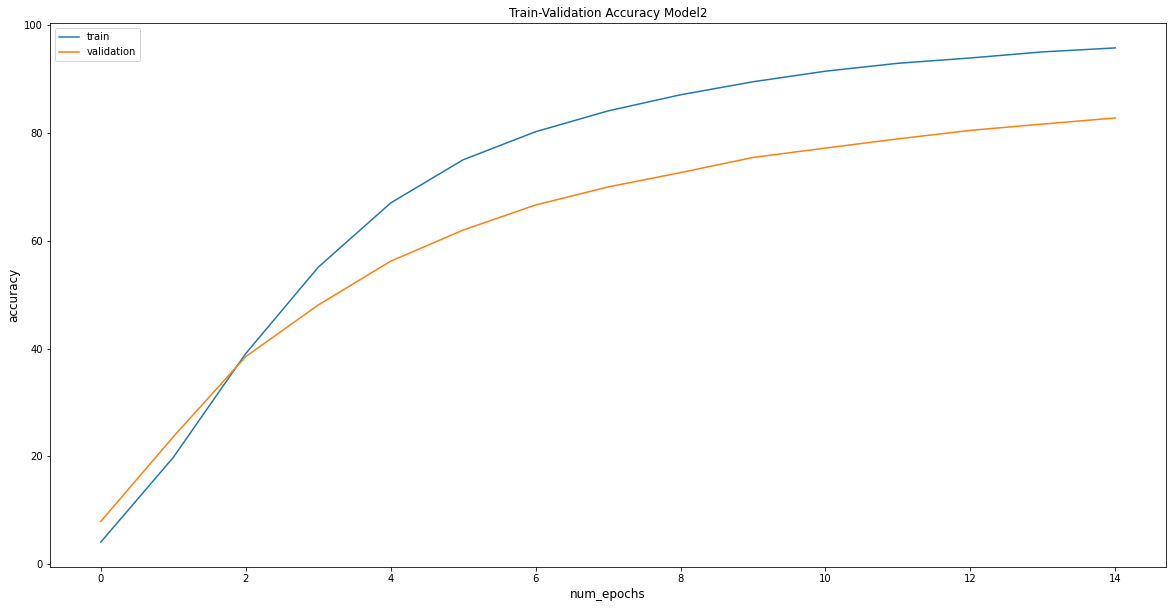

In [13]:
fig = plt.figure(figsize=(20,10))
plt.title("Train-Validation Accuracy Model2")
plt.plot(train_acc2, label='train')
plt.plot(val_acc2, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')

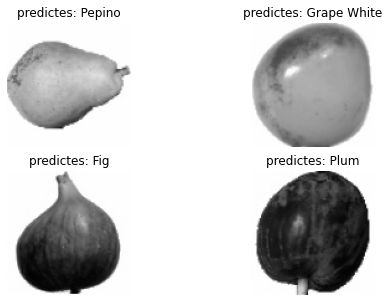

In [14]:
plt.ion()
visualize_model(model2, 4, test_dataloader2, test_dataset2)
plt.ioff()

In [15]:
model3_transforms = transforms.Compose(
[
    transforms.ToTensor(),
    transforms.GaussianBlur(5,(3,3)),
])

train_dataset3 = datasets.ImageFolder(root= train_data_path, transform=model3_transforms)
test_dataset3 = datasets.ImageFolder(root= test_data_path, transform=model3_transforms)
train_dataloader3 = DataLoader(train_dataset3, batch_size=batch_size, shuffle=True)
test_dataloader3 = DataLoader(test_dataset3, batch_size=batch_size, shuffle=True)

model3 = models.resnet18(pretrained=True)
model3 = model3.cuda() if device else model3

criterion3 = nn.CrossEntropyLoss()
sgd_optimizer3 = optim.SGD(model3.parameters(), lr=0.0001, momentum=0.9)

num_features = model3.fc.in_features
model3.fc = nn.Linear(num_features, batch_size)
model3.fc = model3.fc.cuda()

In [16]:
train_acc3,val_acc3 = train_model(model3,epoches,criterion3,sgd_optimizer3,train_dataloader3,test_dataloader3,device)

Epoch 1

Epoch [1/15], Step [0/201], Loss: 5.0982
Epoch [1/15], Step [100/201], Loss: 4.5411
Epoch [1/15], Step [200/201], Loss: 5.2568

train-loss: 4.6368, train-acc: 4.5302
validation loss: 4.3052, validation acc: 11.0178

Epoch 2

Epoch [2/15], Step [0/201], Loss: 4.2706
Epoch [2/15], Step [100/201], Loss: 3.8030
Epoch [2/15], Step [200/201], Loss: 5.3723

train-loss: 4.2015, train-acc: 24.3531
validation loss: 3.9936, validation acc: 27.6209

Epoch 3

Epoch [3/15], Step [0/201], Loss: 3.5580
Epoch [3/15], Step [100/201], Loss: 3.2072
Epoch [3/15], Step [200/201], Loss: 4.5026

train-loss: 3.8509, train-acc: 45.0882
validation loss: 3.7357, validation acc: 40.9415

Epoch 4

Epoch [4/15], Step [0/201], Loss: 3.0162
Epoch [4/15], Step [100/201], Loss: 2.7201
Epoch [4/15], Step [200/201], Loss: 4.4625

train-loss: 3.5625, train-acc: 61.6670
validation loss: 3.5192, validation acc: 52.2646

Epoch 5

Epoch [5/15], Step [0/201], Loss: 2.5115
Epoch [5/15], Step [100/201], Loss: 2.4707
Epoc

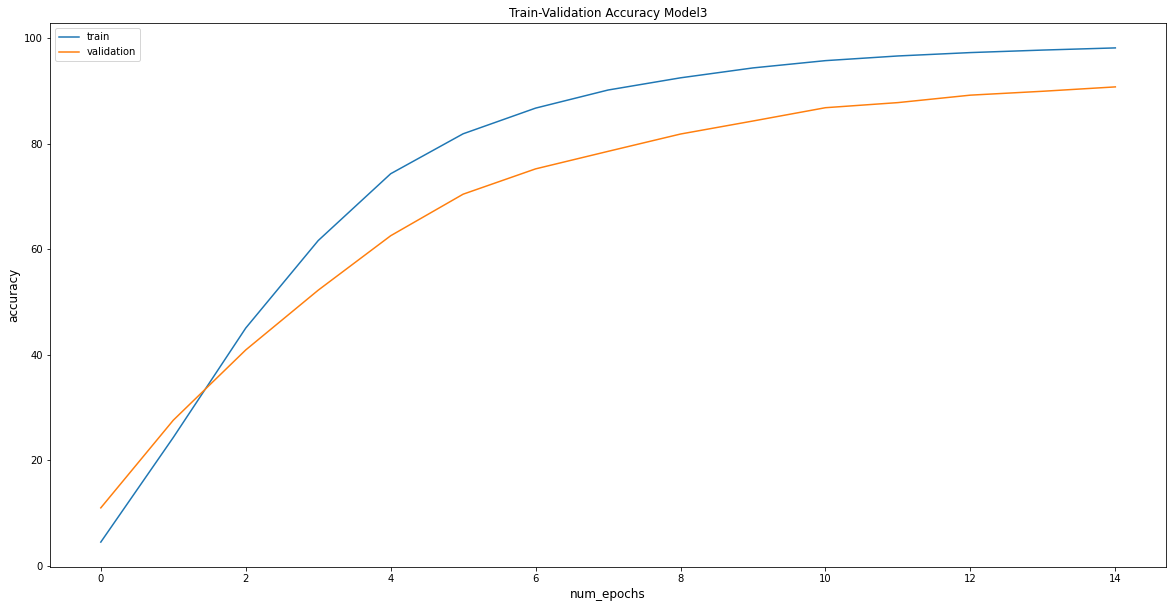

In [17]:
fig = plt.figure(figsize=(20,10))
plt.title("Train-Validation Accuracy Model3")
plt.plot(train_acc3, label='train')
plt.plot(val_acc3, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')

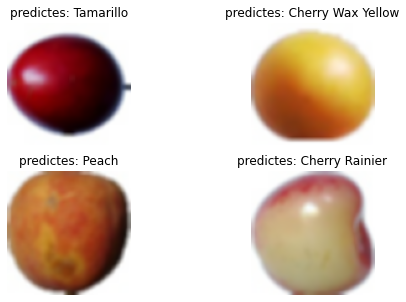

In [18]:
plt.ion()
visualize_model(model3, 4, test_dataloader3, test_dataset3)
plt.ioff()

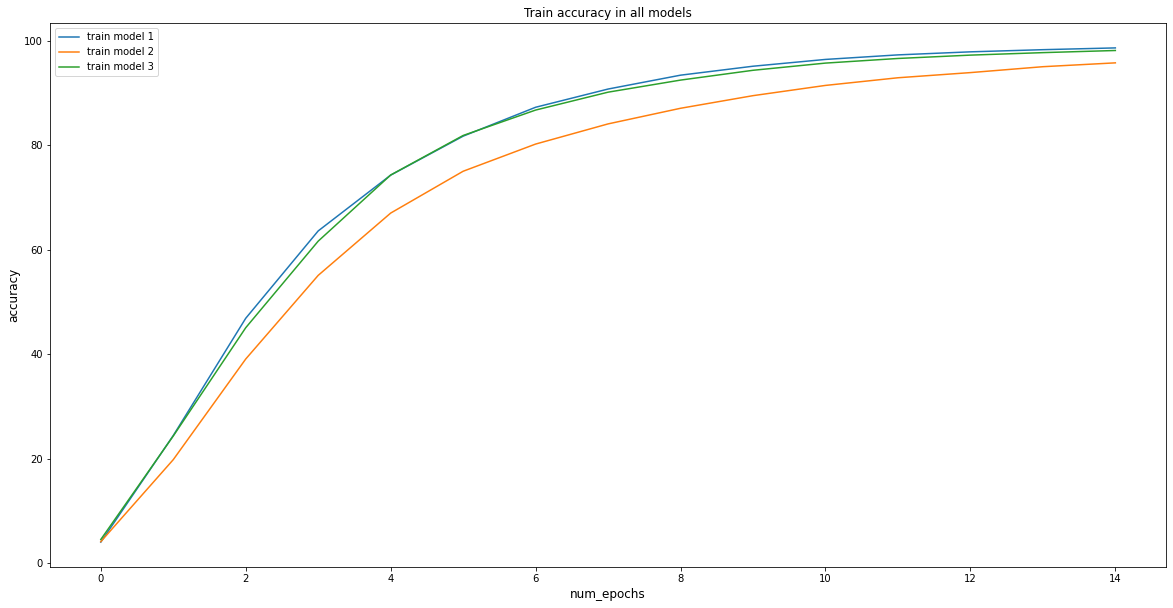

In [19]:
fig = plt.figure(figsize=(20,10))
plt.title("Train accuracy in all models")
plt.plot(train_acc1, label='train model 1')
plt.plot(train_acc2, label='train model 2')
plt.plot(train_acc3, label='train model 3')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')

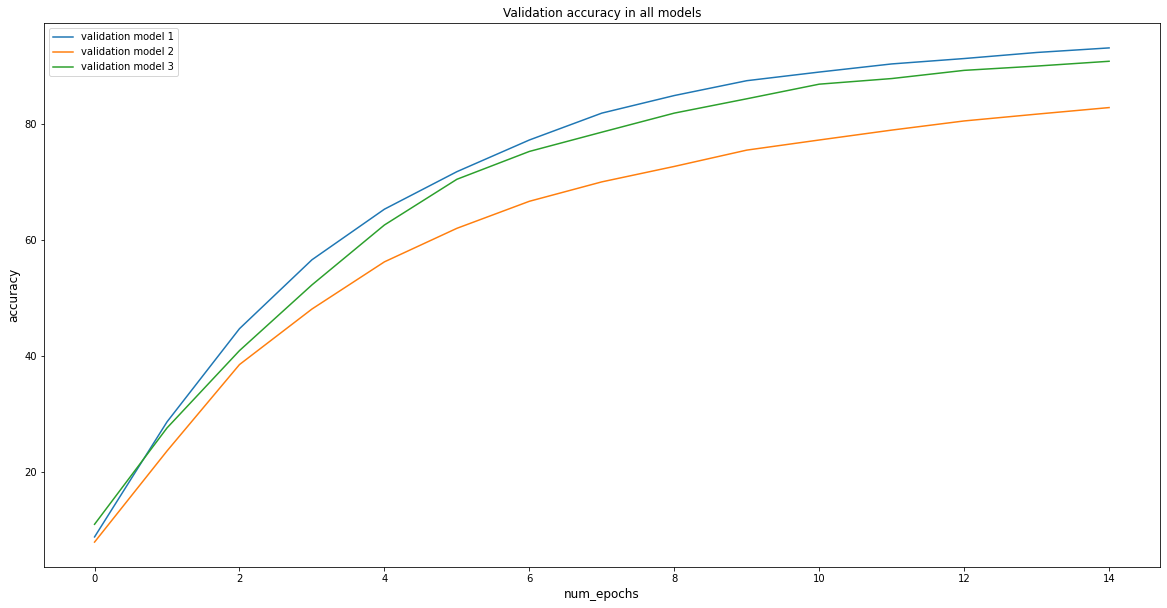

In [20]:
fig = plt.figure(figsize=(20,10))
plt.title("Validation accuracy in all models")
plt.plot(val_acc1, label='validation model 1')
plt.plot(val_acc2, label='validation model 2')
plt.plot(val_acc3, label='validation model 3')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')